# Project 2
### Logistic Regression of Galaxy Morphological Type Frequencies by Redshift

### 1. Importing Packages and Reading in the Data

In [4]:
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import matplotlib.pyplot as plt
import math

### 2. Visual Inspection of Data

In [5]:
df = pd.read_csv('GalaxyMorphZ.tsv', sep="\t")
df=df.sample(n=50000,random_state=5731)
df.head()

,objID,z,SVMPython,RFPython
119323,1237674650461798526,0.098945,1,1
301753,1237652599025173241,0.081600,1,1
265959,1237665129100411317,0.023152,1,1
266280,1237654948912431302,0.066669,0,0
289383,1237662306740207964,0.032803,1,1


In [6]:
df.describe()

,objID,z,SVMPython,RFPython
count,5.000000e+04,50000.000000,50000.000000,50000.000000
mean,1.237662e+18,0.063506,0.557780,0.582920
std,6.043641e+12,0.023075,0.496655,0.493081
min,1.237646e+18,0.003015,0.000000,0.000000
25%,1.237658e+18,0.046093,0.000000,0.000000
50%,1.237662e+18,0.067179,1.000000,1.000000
75%,1.237666e+18,0.082197,1.000000,1.000000
max,1.237680e+18,0.100000,1.000000,1.000000


Text(0.5, 1.0, 'Proportions According to SVM')

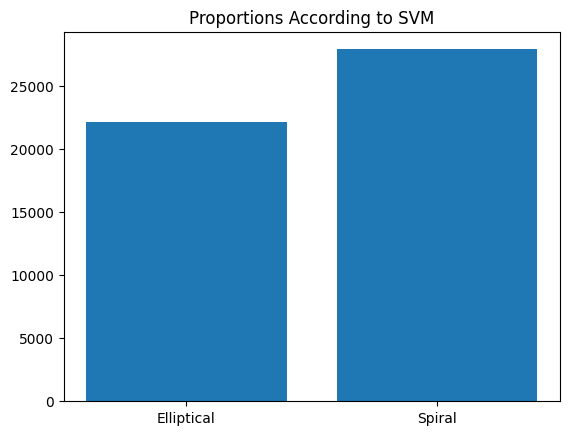

In [7]:
# We will just look at the SVM classifications in this project

N = len(df)

elliptical = df[df['SVMPython']==0]
spiral = df[df['SVMPython']==1]
num_elliptical = len(elliptical)
num_spiral = len(spiral)

plt.bar(['Elliptical','Spiral'],[num_elliptical,num_spiral])
plt.title("Proportions According to SVM")

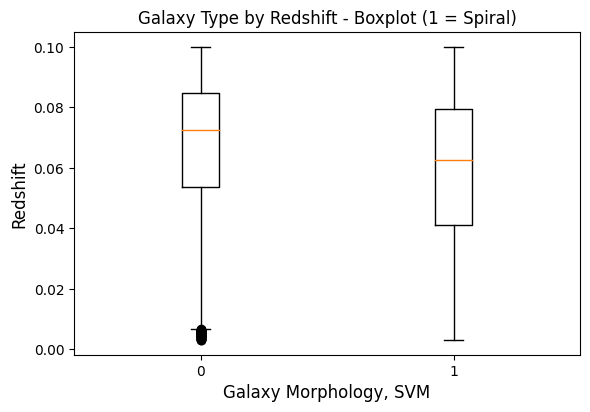

In [8]:
# Boxplot
spirals = df['SVMPython'] == 1

plt.figure(figsize = (6, 4))

plt.boxplot(x = [df['z'][~spirals], df['z'][spirals]], labels = '01');

plt.ylabel('Redshift', fontsize = 12);
plt.xlabel('Galaxy Morphology, SVM', fontsize = 12);


plt.tight_layout()
plt.title("Galaxy Type by Redshift - Boxplot (1 = Spiral)")

plt.show()

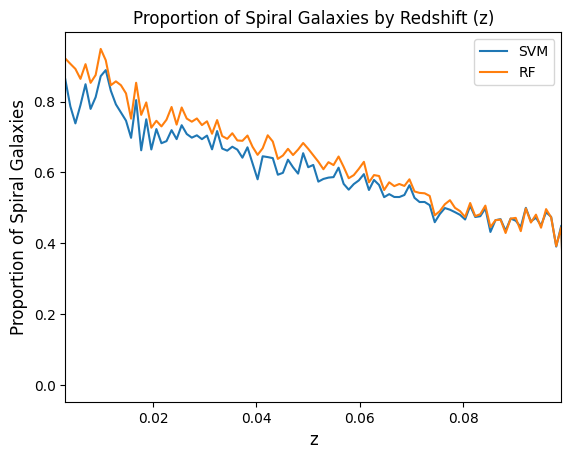

In [9]:
# Plotting proportions of spiral over redshift

x=np.linspace(np.min(df["z"]),np.max(df["z"]),100)
y1=np.zeros(100)
y2=np.zeros(100)
sep=x[1]-x[0]
for i,z in enumerate(x):
    try:
        y1[i]=len(df[(df["SVMPython"]==1)&(df["z"]>z)&(df["z"]<z+sep)])/len(df[(df["z"]>z)&(df["z"]<z+sep)])
    except:
        y1[i]=0
for i,z in enumerate(x):
    try:
        y2[i]=len(df[(df["RFPython"]==1)&(df["z"]>z)&(df["z"]<z+sep)])/len(df[(df["z"]>z)&(df["z"]<z+sep)])
    except:
        y2[i]=0
plt.plot(x,y1,label="SVM")
plt.plot(x,y2,label="RF")
plt.legend()
plt.xlim(x[0],x[-2])
plt.xlabel("z", fontsize=12)
plt.ylabel("Proportion of Spiral Galaxies", fontsize=12)
plt.title("Proportion of Spiral Galaxies by Redshift (z)")
plt.show()


### 3. Establishing Priors and Creating Model

In [10]:
#Minimum Effective Sample Size - we have 6: mean, lb and ub for CI for both b0 and b1

import pymc as pm
import arviz as az
from scipy.stats import chi2
from scipy.special import gamma

def minESS(p,alpha=0.05,epsilon=0.05):
    X2=chi2.ppf(1-alpha, p)
    min_num=np.rint(np.pi*(2./p/gamma(p/2))**(2/p)*X2/epsilon**2)
    return min_num.astype(int)

N_sample = minESS(6).astype(int)

print('Minimum effective size:', N_sample)

Minimum effective size: 8708


In [11]:
# We will use the standard reference prior for our Betas (Normal with tau = 0.01, mu = 0)
y = df['SVMPython']
x = df['z']

# Building the model
with pm.Model() as model:
    # Priors on Beta
    beta0 = pm.Normal('beta0', mu=0, tau=0.01, testval=0.0)
    beta1 = pm.Normal('beta1', mu=0, tau=0.01, testval=0.0)

    # Drawing theta using sigmoid
    theta = pm.Deterministic('theta', pm.math.sigmoid(beta0+beta1*x))

    # Bernoulli output using theta
    observed = pm.Bernoulli('p_spiral',theta,observed=y)

    #start=pm.find_MAP()
    #step = pm.NUTS()
    # Posterior sampling
    #trace = pm.sample(N_sample, step=step, return_inferencedata=True);


<ipython-input-11-8edd82d025e0>:8: FutureWarning: The `testval` argument is deprecated; use `initval`.
  beta0 = pm.Normal('beta0', mu=0, tau=0.01, testval=0.0)
<ipython-input-11-8edd82d025e0>:9: FutureWarning: The `testval` argument is deprecated; use `initval`.
  beta1 = pm.Normal('beta1', mu=0, tau=0.01, testval=0.0)


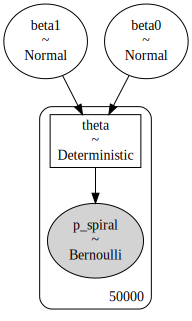

In [12]:
# Visualizing Model
from pymc import Model, Normal, Gamma,model_to_graphviz
model_to_graphviz(model)

In [13]:
# Took about 10 minutes to run this cell
N_sample = 1000
with model:
    #Draw 8708 posterior samples
    idata = pm.sample(N_sample,step=pm.NUTS())
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

### 4. Prior Predictive Check

In [14]:
# We will use the standard reference prior for our Betas (Normal with tau = 1, mu = 0)
y = df['SVMPython']
x = df['z']

# Building the model
with pm.Model() as model:
    # Priors on Beta
    beta0 = pm.Normal('beta0', mu=1, tau=0.01, testval=0.0)
    beta1 = pm.Normal('beta1', mu=1, tau=0.01, testval=0.0)

    # Drawing theta using sigmoid
    theta = pm.Deterministic('theta', pm.math.sigmoid(beta0+beta1*x))

    # Bernoulli output using theta
    observed = pm.Bernoulli('p_spiral',theta,observed=y)

    #start=pm.find_MAP()
    #step = pm.NUTS()
    # Posterior sampling
    #trace = pm.sample(N_sample, step=step, return_inferencedata=True);
# Took about 10 minutes to run this cell
N_sample = 1000
with model:
    #Draw 8708 posterior samples
    idata = pm.sample(N_sample,step=pm.NUTS())
print("Beta0,Beta1 mu=1:")
print(az.summary(idata, var_names=['beta0','beta1'],round_to=4)[['mean','hdi_3%','hdi_97%']])

######################################################################

# We will use the standard reference prior for our Betas (Normal with tau = 0.01, mu = 0)
y = df['SVMPython']
x = df['z']

# Building the model
with pm.Model() as model:
    # Priors on Beta
    beta0 = pm.Normal('beta0', mu=0.01, tau=0.01, testval=0.0)
    beta1 = pm.Normal('beta1', mu=0.01, tau=0.01, testval=0.0)

    # Drawing theta using sigmoid
    theta = pm.Deterministic('theta', pm.math.sigmoid(beta0+beta1*x))

    # Bernoulli output using theta
    observed = pm.Bernoulli('p_spiral',theta,observed=y)

    #start=pm.find_MAP()
    #step = pm.NUTS()
    # Posterior sampling
    #trace = pm.sample(N_sample, step=step, return_inferencedata=True);
# Took about 10 minutes to run this cell
N_sample = 1000
with model:
    #Draw 8708 posterior samples
    idata = pm.sample(N_sample,step=pm.NUTS())
print("Beta0,Beta1 mu=0.01:")
print(az.summary(idata, var_names=['beta0','beta1'],round_to=4)[['mean','hdi_3%','hdi_97%']])
# The posterior is very insensitive to the prior!

<ipython-input-14-e29c3805f980>:8: FutureWarning: The `testval` argument is deprecated; use `initval`.
  beta0 = pm.Normal('beta0', mu=1, tau=0.01, testval=0.0)
<ipython-input-14-e29c3805f980>:9: FutureWarning: The `testval` argument is deprecated; use `initval`.
  beta1 = pm.Normal('beta1', mu=1, tau=0.01, testval=0.0)


Beta0,Beta1 mu=1:


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


          mean   hdi_3%  hdi_97%
beta0   1.2458   1.1963   1.2968
beta1 -15.8192 -16.6033 -15.1207


<ipython-input-14-e29c3805f980>:38: FutureWarning: The `testval` argument is deprecated; use `initval`.
  beta0 = pm.Normal('beta0', mu=0.01, tau=0.01, testval=0.0)
<ipython-input-14-e29c3805f980>:39: FutureWarning: The `testval` argument is deprecated; use `initval`.
  beta1 = pm.Normal('beta1', mu=0.01, tau=0.01, testval=0.0)


Beta0,Beta1 mu=0.01:
          mean   hdi_3%  hdi_97%
beta0   1.2430   1.1901   1.2928
beta1 -15.7772 -16.5779 -15.0816


### 5. Posterior Distributions

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta0'}>],
       [<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta1'}>]], dtype=object)

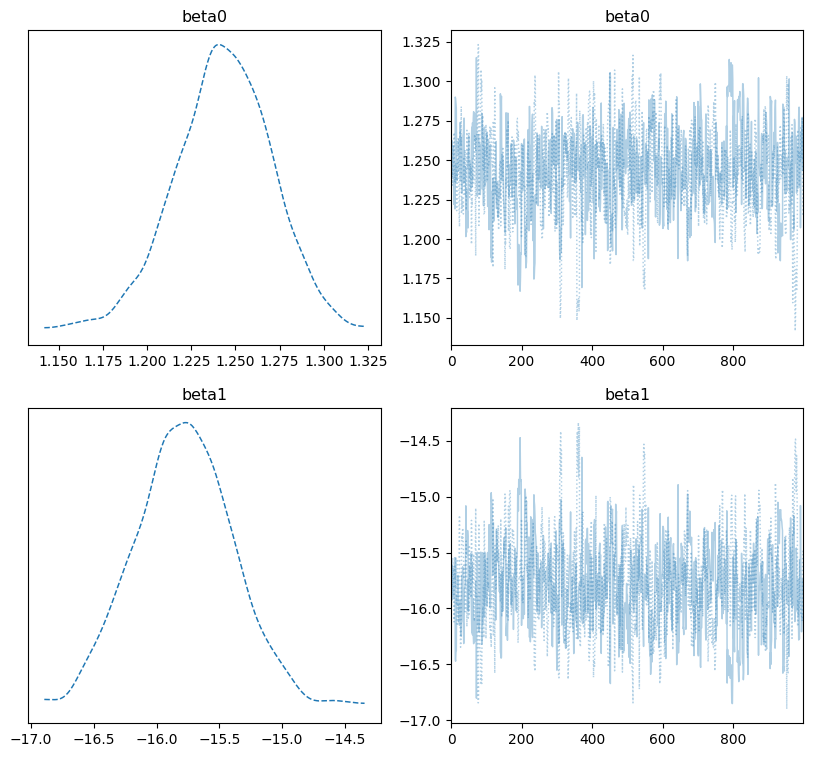

In [15]:
# Posterior Distributions
az.plot_trace(idata,var_names=['beta0','beta1'],figsize=(10, 9), combined=True) #Use 'combined=true' to show all chains together

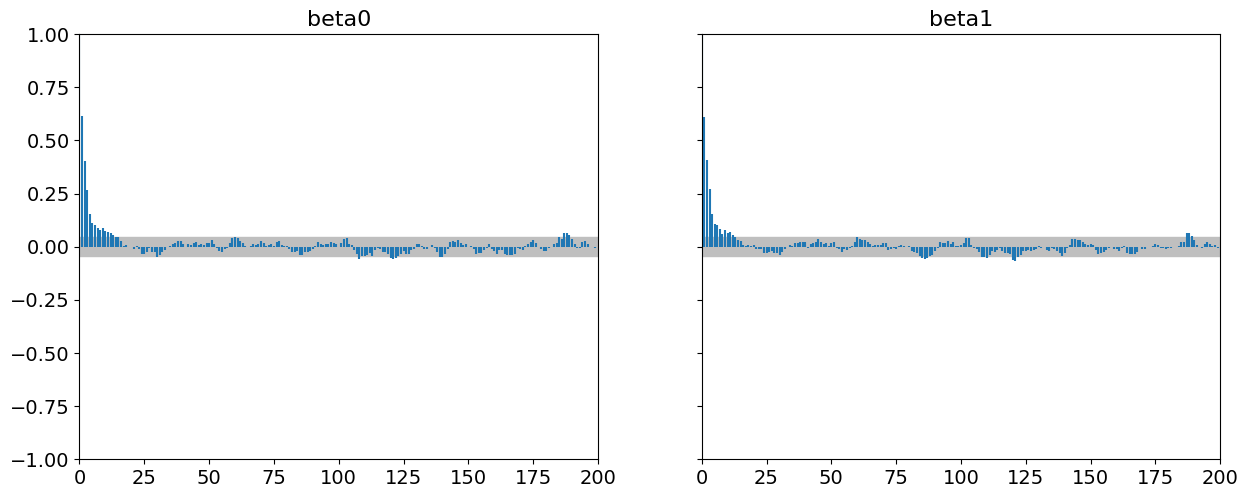

In [16]:
# Auto Correlation Plots
az.plot_autocorr(idata, var_names=['beta0','beta1'],combined=True, max_lag=200);


### 6. Sensitivity Analysis

In [17]:
# To Do

### 7. Posterior Predictive Check

In [18]:
# To Do

### 8. Final Results

In [19]:
# Summary
az.summary(idata, var_names=['beta0','beta1'],round_to=4)[['mean','hdi_3%','hdi_97%']]


,mean,hdi_3%,hdi_97%
beta0,1.2430,1.1901,1.2928
beta1,-15.7772,-16.5779,-15.0816


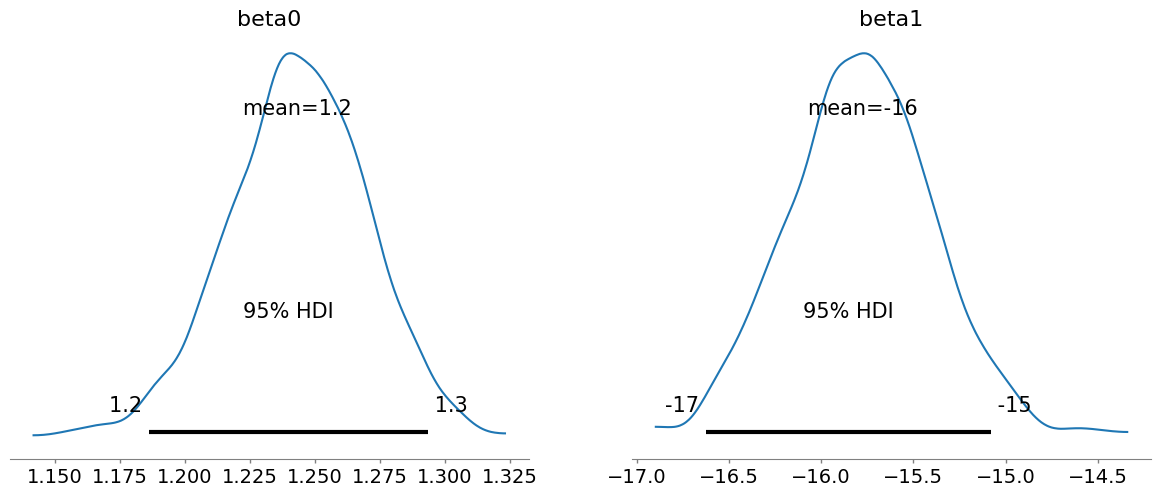

In [20]:
# Posterior Plots with Credible Interval
az.plot_posterior(idata, var_names=['beta0','beta1'], hdi_prob=.95);


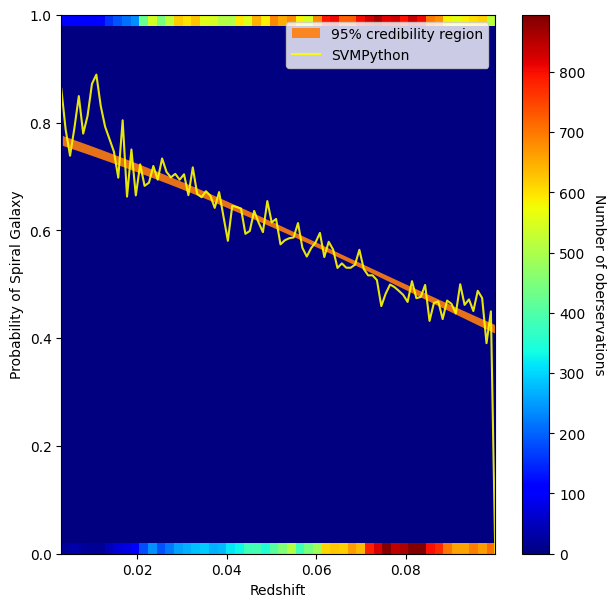

In [81]:
# To Do: Plot original data (maybe some randomly sampled points since we have so many?) and Logistic regression fit line
f, ax1 = plt.subplots(figsize=(7, 7))

y = df['SVMPython']
x = df['z']


res = ax1.hist2d(x, y, (50, 50), cmap=plt.cm.jet)
cbar = f.colorbar(res[3], ax = ax1)
cbar.set_label('Number of oberservations', rotation=270, labelpad=15)

# Code for Confidence Interval:
az.plot_hdi(x,
    idata.posterior.theta,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.90, "linewidth": 0, "label":"95% credibility region"},
    color="C1", plot_kwargs={},
    ax = ax1
)

x=np.linspace(np.min(df["z"]),np.max(df["z"]),100)
y1=np.zeros(100)
for i,z in enumerate(x):
    try:
        y1[i]=len(df[(df["SVMPython"]==1)&(df["z"]>z)&(df["z"]<z+sep)])/len(df[(df["z"]>z)&(df["z"]<z+sep)])
    except:
        y1[i]=0

#ax1.xlim(x[0],x[-2])
ax1.plot(x,y1,label="SVMPython", color='yellow', alpha = .9)

ax1.set_xlabel('Redshift')
ax1.set_ylabel('Probability of Spiral Galaxy')
ax1.legend()